# Naive Bayes PGM

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pgmpy

## Load Data

In [129]:
df_raw = pd.read_csv('crispr13d_lfc.csv')
print(df_raw.head())
print(df_raw.shape)

                          spacer_seq  log_fold_change
0  CTGCAGGACAGGTGGGCGTGGCCCGAGCNNNNN        -0.016079
1  GCTGCAGGACAGGTGGGCGTGGCCCGAGCNNNN         0.169027
2  TGCTGCAGGACAGGTGGGCGTGGCCCGAGCNNN         0.068603
3  AGTGCTGCAGGACAGGTGGGCGTGGCCCGAGCN         0.218402
4  CAGTGCTGCAGGACAGGTGGGCGTGGCCCGAGC         0.028038
(5726, 2)


Min LFC: -3.4002907331710466  - Max LFC: 3.742225197817132


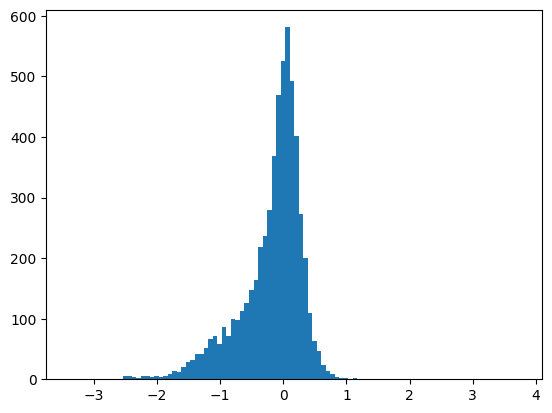

In [130]:
print("Min LFC:", np.min(df_raw['log_fold_change']), " - Max LFC:", np.max(df_raw['log_fold_change']))
plt.hist(df_raw['log_fold_change'], bins=100)
plt.show()

### Format Data

In [131]:
df_spacer_split = df_raw['spacer_seq'].apply(lambda x: pd.Series(list(x)))
df_spacer_split.columns = [f'SP{str(i+1).zfill(2)}' for i in range(df_spacer_split.shape[1])]
df = pd.concat([df_spacer_split, df_raw.drop(['spacer_seq'], axis=1)], axis=1)
df['log_fold_change'] = df['log_fold_change'].apply(lambda x: (((2*(x+0.25))//1) / 2))  # Data bucketing: -0.25->0.25: 0, 0.25->0.75: 0.5, etc.
print(df.head())

  SP01 SP02 SP03 SP04 SP05 SP06 SP07 SP08 SP09 SP10  ... SP25 SP26 SP27 SP28  \
0    C    T    G    C    A    G    G    A    C    A  ...    G    A    G    C   
1    G    C    T    G    C    A    G    G    A    C  ...    C    G    A    G   
2    T    G    C    T    G    C    A    G    G    A  ...    C    C    G    A   
3    A    G    T    G    C    T    G    C    A    G  ...    G    C    C    C   
4    C    A    G    T    G    C    T    G    C    A  ...    G    G    C    C   

  SP29 SP30 SP31 SP32 SP33 log_fold_change  
0    N    N    N    N    N             0.0  
1    C    N    N    N    N             0.0  
2    G    C    N    N    N             0.0  
3    G    A    G    C    N             0.0  
4    C    G    A    G    C             0.0  

[5 rows x 34 columns]


Min LFC: -3.5  - Max LFC: 3.5


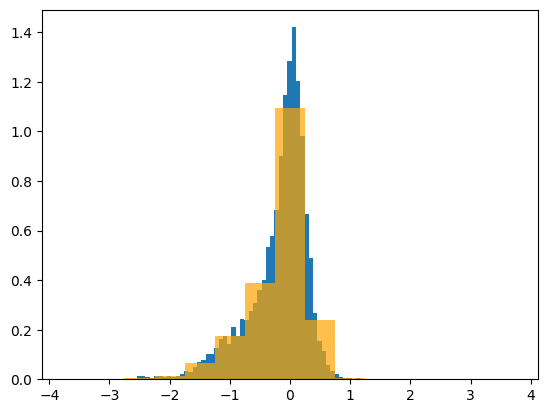

In [132]:
print("Min LFC:", np.min(df['log_fold_change']), " - Max LFC:", np.max(df['log_fold_change']))
plt.hist(df_raw['log_fold_change'], bins=100, density=True)
bins = np.arange(np.min(df['log_fold_change']) - 0.25, np.max(df['log_fold_change']) + 0.25, 0.5)
plt.hist(df['log_fold_change'], bins=bins, color='orange', alpha=0.7, density=True)
plt.show()

### Shuffle Data

In [133]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)
print(shuffled_df.head())

  SP01 SP02 SP03 SP04 SP05 SP06 SP07 SP08 SP09 SP10  ... SP25 SP26 SP27 SP28  \
0    G    T    T    T    C    T    G    A    A    C  ...    T    G    G    A   
1    T    T    A    T    A    A    A    T    G    T  ...    T    T    A    A   
2    A    G    C    A    C    T    T    A    A    A  ...    G    G    A    A   
3    G    G    C    C    C    A    A    T    T    T  ...    A    A    A    A   
4    G    G    A    C    G    C    G    C    C    G  ...    A    G    T    C   

  SP29 SP30 SP31 SP32 SP33 log_fold_change  
0    A    G    T    T    A            -1.5  
1    G    T    A    G    A             0.0  
2    T    A    T    T    C             0.0  
3    T    T    T    C    A             0.5  
4    G    C    A    G    C             0.0  

[5 rows x 34 columns]


### Split Data - Train/Test - 80/20

In [134]:
train_length = int(shuffled_df.shape[0]*0.8)
train_data =  shuffled_df.iloc[:train_length].reset_index(drop=True)
test_data =  shuffled_df.iloc[train_length:].reset_index(drop=True)

print("Total Data:", shuffled_df.shape[0])

print("Train Data")
print(train_data.head())
print(train_data.shape)
print()

print("Test Data:")
print(test_data.head())
print(test_data.shape)

Total Data: 5726
Train Data
  SP01 SP02 SP03 SP04 SP05 SP06 SP07 SP08 SP09 SP10  ... SP25 SP26 SP27 SP28  \
0    G    T    T    T    C    T    G    A    A    C  ...    T    G    G    A   
1    T    T    A    T    A    A    A    T    G    T  ...    T    T    A    A   
2    A    G    C    A    C    T    T    A    A    A  ...    G    G    A    A   
3    G    G    C    C    C    A    A    T    T    T  ...    A    A    A    A   
4    G    G    A    C    G    C    G    C    C    G  ...    A    G    T    C   

  SP29 SP30 SP31 SP32 SP33 log_fold_change  
0    A    G    T    T    A            -1.5  
1    G    T    A    G    A             0.0  
2    T    A    T    T    C             0.0  
3    T    T    T    C    A             0.5  
4    G    C    A    G    C             0.0  

[5 rows x 34 columns]
(4580, 34)

Test Data:
  SP01 SP02 SP03 SP04 SP05 SP06 SP07 SP08 SP09 SP10  ... SP25 SP26 SP27 SP28  \
0    G    A    T    T    T    A    T    A    A    C  ...    C    T    G    C   
1    T    A    

### Test mean estimate accuracy

In [135]:
mean_est = np.mean(train_data['log_fold_change'])
print("Always estimate change of:", mean_est)
mean_errors = test_data['log_fold_change'] - mean_est
print("Errors:")
print(mean_errors)
print("MSE Loss: ", np.sum(np.square(mean_errors))/test_data.shape[0])

Always estimate change of: -0.18919213973799126
Errors:
0       0.189192
1      -0.310808
2      -0.310808
3       0.189192
4       0.189192
          ...   
1141    0.189192
1142    0.189192
1143    0.189192
1144   -0.310808
1145   -0.810808
Name: log_fold_change, Length: 1146, dtype: float64
MSE Loss:  0.2900197759225335


## Prepare Bayesian Network - Naive Bayes

In [136]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork()
model.add_edges_from([(df.columns[-1], s) for s in df.columns[:-1]])
model.to_graphviz().draw("naive-bayes.png", prog="dot")
# model_daft = model.to_daft()
# model_daft.render()
# model_daft.savefig('naive-bayes-daft.png')

from pgmpy.estimators import MaximumLikelihoodEstimator
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

from pgmpy.readwrite import XMLBIFWriter
writer = XMLBIFWriter(model)
writer.write_xmlbif('naive-bayes.xml')

cpds = model.get_cpds()
for cpd in cpds:
    print(cpd)

# DO NOT UNCOMMENT - LOADING MODELS KILLED MY PC TWICE!!!
# model.save('naive-model.bif', filetype='bif')

+-----------------+-----+----------------------+
| log_fold_change | ... | log_fold_change(3.5) |
+-----------------+-----+----------------------+
| SP01(A)         | ... | 0.0                  |
+-----------------+-----+----------------------+
| SP01(C)         | ... | 1.0                  |
+-----------------+-----+----------------------+
| SP01(G)         | ... | 0.0                  |
+-----------------+-----+----------------------+
| SP01(N)         | ... | 0.0                  |
+-----------------+-----+----------------------+
| SP01(T)         | ... | 0.0                  |
+-----------------+-----+----------------------+
+-----------------+-----+----------------------+
| log_fold_change | ... | log_fold_change(3.5) |
+-----------------+-----+----------------------+
| SP02(A)         | ... | 0.0                  |
+-----------------+-----+----------------------+
| SP02(C)         | ... | 0.0                  |
+-----------------+-----+----------------------+
| SP02(G)         | 

### Train BN on Data

In [137]:
test_pred = model.predict(test_data.iloc[:, :-1])
print(test_pred)

100%|██████████| 1146/1146 [00:00<00:00, 1339.74it/s]


      log_fold_change
0                 0.0
1                 0.0
2                 0.0
3                 0.0
4                 0.0
...               ...
1141              0.0
1142              0.0
1143              0.0
1144              0.0
1145              0.0

[1146 rows x 1 columns]


### Run BN on Data

In [138]:
errors = test_data['log_fold_change'] - test_pred['log_fold_change']
print("Errors:")
print(errors)
print("MSE Loss: ", np.sum(np.square(errors))/test_data.shape[0])

Errors:
0       0.0
1      -0.5
2      -0.5
3       0.0
4       0.0
       ... 
1141    0.0
1142    0.0
1143    0.0
1144   -0.5
1145   -1.0
Name: log_fold_change, Length: 1146, dtype: float64
MSE Loss:  0.31893542757417104


## Learning BN

In [139]:
from pgmpy.estimators import HillClimbSearch
est = HillClimbSearch(train_data, use_cache=True)
dag = est.estimate(start_dag=model , scoring_method='bdeuscore')
print(len(dag.nodes()))
print(len(dag.edges()))

model_sl = BayesianNetwork(dag)
model_sl.to_graphviz().draw("struct-learn.png", prog="dot")

from pgmpy.estimators import MaximumLikelihoodEstimator
model_sl.fit(train_data, estimator=MaximumLikelihoodEstimator)

from pgmpy.readwrite import XMLBIFWriter
writer = XMLBIFWriter(model_sl)
writer.write_xmlbif('struct-learn.xml')

cpds = model_sl.get_cpds()
for cpd in cpds:
    print(cpd)

  0%|          | 57/1000000 [00:05<27:02:01, 10.27it/s]


34
30
+---------+---------------------+-----+---------+---------------------+
| SP02    | SP02(A)             | ... | SP02(N) | SP02(T)             |
+---------+---------------------+-----+---------+---------------------+
| SP01(A) | 0.3518648838845883  | ... | 0.0     | 0.25171102661596956 |
+---------+---------------------+-----+---------+---------------------+
| SP01(C) | 0.2547501759324419  | ... | 0.0     | 0.23574144486692014 |
+---------+---------------------+-----+---------+---------------------+
| SP01(G) | 0.17804363124560169 | ... | 0.0     | 0.17642585551330797 |
+---------+---------------------+-----+---------+---------------------+
| SP01(N) | 0.0                 | ... | 1.0     | 0.0                 |
+---------+---------------------+-----+---------+---------------------+
| SP01(T) | 0.21534130893736805 | ... | 0.0     | 0.3361216730038023  |
+---------+---------------------+-----+---------+---------------------+
+---------+-------------+
| SP02(A) | 0.310262    |
+-----

In [140]:
test_pred = model_sl.predict(test_data.iloc[:, :-1])
print(test_pred)

100%|██████████| 1146/1146 [00:00<00:00, 1543.20it/s]


      log_fold_change
0                 0.0
1                 0.0
2                 0.0
3                 0.0
4                 0.0
...               ...
1141              0.0
1142              0.0
1143              0.0
1144              0.0
1145              0.0

[1146 rows x 1 columns]


In [141]:
errors = test_data['log_fold_change'] - test_pred['log_fold_change']
print("Errors:")
print(errors)
print("MSE Loss: ", np.sum(np.square(errors))/test_data.shape[0])

Errors:
0       0.0
1      -0.5
2      -0.5
3       0.0
4       0.0
       ... 
1141    0.0
1142    0.0
1143    0.0
1144   -0.5
1145   -1.0
Name: log_fold_change, Length: 1146, dtype: float64
MSE Loss:  0.3322425828970332
